# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.


It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [27]:
import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

pincirollis_data_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/multi_N25.csv"
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/pinciroli_replication_1/'


## Dataframe creation

In [28]:
import gssi_experiment.util.util as util
import gssi_experiment.util.stat_helper as stat_helper

TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["gateway-aggregator", "s1", "s2", "s3"]


def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=2
    ):
        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate s3 intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())
        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(experiment_folder).split("_")[0])
        s3_intensity = 1 - (step / max_steps)

        # Calculates CPU utilization data.
        utilization_data = stat_helper.calculate_average_cpu_time(
            experiment_folder, service_cols
        )

        data_point = [
            step,
            max_steps,
            s3_intensity,
            avg_latency,
            cpu_limit,
            replicas,
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    "s3_intensity",
    "avg_latency_ms",
    "cpu_limit",
    "replicas",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df

,step,max_step,s3_intensity,avg_latency_ms,cpu_limit,replicas,cpu_utilization_gateway-aggregator,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3
0,0,5,1.0,933.275470,1000m,1,0.041391,0.320087,0.651374,0.865186
1,1,5,0.8,693.652427,1000m,1,0.060231,0.653799,0.875498,0.758761
2,2,5,0.6,637.784248,1000m,1,0.056446,0.717111,0.811429,0.666327
3,3,5,0.4,664.993287,1000m,1,0.056425,0.755567,0.839002,0.690957
4,4,5,0.2,766.953095,1000m,1,0.049398,0.856969,0.641931,0.542322
5,5,5,0.0,854.942888,1000m,1,0.043343,0.854448,0.548787,0.269835


In [29]:
pinc_df = synth_df[["N_A", "R0"]]
pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on="s3_intensity")

df

/tmp/ipykernel_21543/1627540373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)


,step,max_step,s3_intensity,avg_latency_ms,cpu_limit,replicas,cpu_utilization_gateway-aggregator,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0
0,0,5,1.0,933.275470,1000m,1,0.041391,0.320087,0.651374,0.865186,501.080456
1,1,5,0.8,693.652427,1000m,1,0.060231,0.653799,0.875498,0.758761,387.771535
2,2,5,0.6,637.784248,1000m,1,0.056446,0.717111,0.811429,0.666327,349.225049
3,3,5,0.4,664.993287,1000m,1,0.056425,0.755567,0.839002,0.690957,342.748978
4,5,5,0.0,854.942888,1000m,1,0.043343,0.854448,0.548787,0.269835,449.008131


In [30]:
pinc_df = synth_df[["N_A", "Ugw", "Us1", "Us2", "Us3"]]
pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on="s3_intensity")

df

/tmp/ipykernel_21543/3698107938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)


,step,max_step,s3_intensity,avg_latency_ms,cpu_limit,replicas,cpu_utilization_gateway-aggregator,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,R0,Ugw,Us1,Us2,Us3
0,0,5,1.0,933.275470,1000m,1,0.041391,0.320087,0.651374,0.865186,501.080456,0.498132,0.350410,0.739736,1.000000
1,1,5,0.8,693.652427,1000m,1,0.060231,0.653799,0.875498,0.758761,387.771535,0.645042,0.665800,0.910665,0.999964
2,2,5,0.6,637.784248,1000m,1,0.056446,0.717111,0.811429,0.666327,349.225049,0.716111,0.859453,0.985620,0.951204
3,3,5,0.4,664.993287,1000m,1,0.056425,0.755567,0.839002,0.690957,342.748978,0.729392,0.971041,0.970597,0.828684
4,5,5,0.0,854.942888,1000m,1,0.043343,0.854448,0.548787,0.269835,449.008131,0.560574,0.999943,0.663446,0.280486


# Request Delay


## Visualization


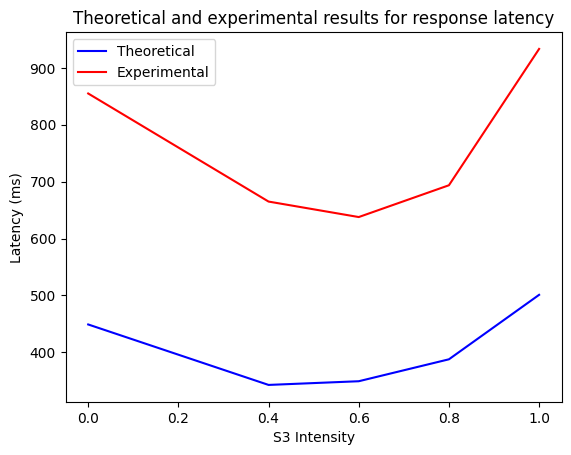

In [31]:
def create_figure(df: pd.DataFrame, synth_key: str, real_key: str):
    # Create a figure and axis
    plt.figure()
    ax = plt.axes()

    # Plot the first line (sine function)
    ax.plot(df["s3_intensity"], df[synth_key], label="Theoretical", color="blue")

    # Plot the second line (cosine function)
    ax.plot(df["s3_intensity"], df[real_key], label="Experimental", color="red")

    # Add labels and a legend
    ax.set_ylabel("Latency (ms)")
    ax.set_xlabel("S3 Intensity")
    ax.set_title("Theoretical and experimental results for response latency")
    ax.legend()

    # Show the plot
    plt.show()


create_figure(df, "R0", "avg_latency_ms")

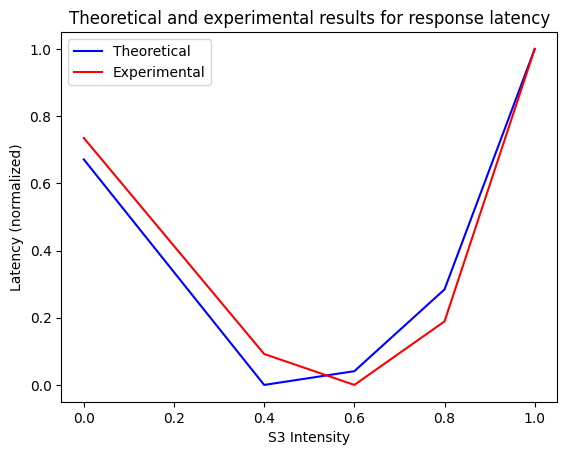

In [32]:
# Normalized data


def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = pd.DataFrame()
df_norm["s3_intensity"] = df["s3_intensity"]

r0_min, r0_max = min(df["R0"]), max(df["R0"])
df_norm["R0"] = df["R0"].transform(lambda x: normalize(x, r0_min, r0_max))

lat_min, lat_max = min(df["avg_latency_ms"]), max(df["avg_latency_ms"])
df_norm["avg_latency_ms"] = df["avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.plot(df_norm["s3_intensity"], df_norm["R0"], label="Theoretical", color="blue")

# Plot the second line (cosine function)
ax.plot(
    df_norm["s3_intensity"],
    df_norm["avg_latency_ms"],
    label="Experimental",
    color="red",
)

# Add labels and a legend
ax.set_ylabel("Latency (normalized)")
ax.set_xlabel("S3 Intensity")
ax.set_title("Theoretical and experimental results for response latency")
ax.legend()

# Show the plot
plt.show()

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


In [33]:
correlation_coefficient, p_value = spearmanr(df["R0"], df["avg_latency_ms"])

# Display the result
print(f"Spearman's correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Spearman's correlation coefficient: 0.8999999999999998
P-value: 0.03738607346849874


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [34]:
def mape(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele) / expected_ele)
    m /= len(expected)
    return m


absolute_mape = mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = mape(df_norm["R0"] + eps, df_norm["avg_latency_ms"] + eps)

print(f"{absolute_mape=}, {normalized_mape=} ({eps=})")

absolute_mape=0.46317967350629863, normalized_mape=0.0484245795774219 (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [35]:
def mae(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele))
    m /= len(expected)
    return m


absolute_mae = mae(df["R0"], df["avg_latency_ms"])
normalized_mae = mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=}, {normalized_mae=}")

absolute_mae=350.96283412366876, normalized_mae=0.058411824522742926


# Visualizing the relationship

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


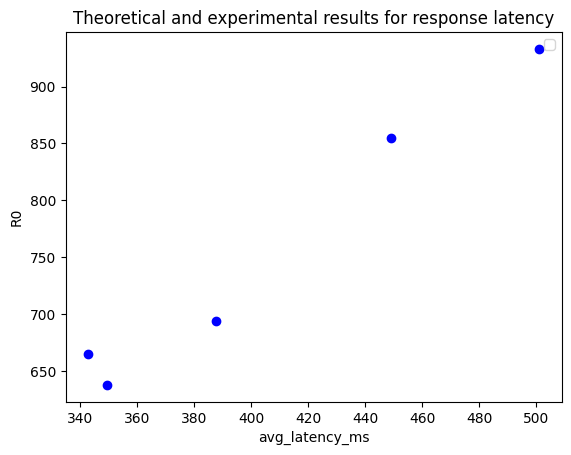

In [36]:
# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.scatter(df["R0"], df["avg_latency_ms"], color="blue")

# Add labels and a legend
ax.set_ylabel("R0")
ax.set_xlabel("avg_latency_ms")
ax.set_title("Theoretical and experimental results for response latency")
ax.legend()

# Show the plot
plt.show()

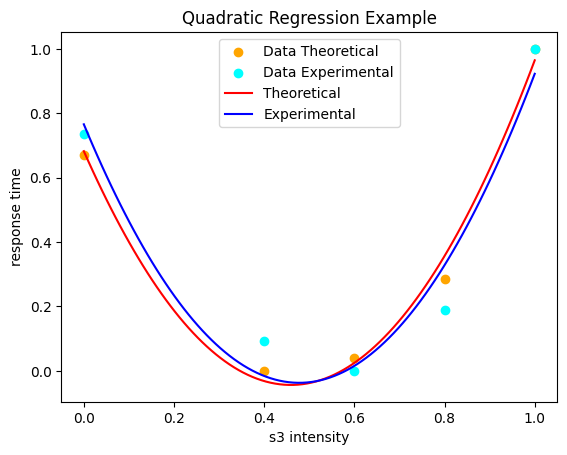

In [37]:
import numpy as np
import matplotlib.pyplot as plt


def normalize_field(df: pd.DataFrame, field: str) -> pd.DataFrame:
    min_x, max_x = min(df[field]), max(df[field])
    df.loc[:, field] = df[field].transform(lambda x: normalize(x, min_x, max_x))
    return df

test_df = df.copy()
test_df = normalize_field(test_df, "R0")
test_df = normalize_field(test_df, "avg_latency_ms")

test_df


def make_model(x, y):
    # Fit a quadratic regression model
    coefficients = np.polyfit(x, y, 2)
    quadratic_model = np.poly1d(coefficients)

    # Generate y values from the model for smooth plotting
    x_smooth = np.linspace(min(x), max(x), 100)
    y_smooth = quadratic_model(x_smooth)
    return x_smooth, y_smooth


# Sample data
# x = np.array([1, 2, 3, 4, 5])
# y = np.array([3, 8, 12, 8, 3])
x = test_df["s3_intensity"].tolist()
y = test_df["R0"].tolist()
x_smooth, y_smooth = make_model(x, y)

y2 = test_df["avg_latency_ms"].tolist()
x2_smooth, y2_smooth = make_model(x, y2)

# Plot the data and the quadratic regression curve
plt.scatter(x, y, label='Data Theoretical', color='orange')
plt.scatter(x, y2, label='Data Experimental', color='cyan')
plt.plot(x_smooth, y_smooth, color="red", label="Theoretical")
plt.plot(x2_smooth, y2_smooth, color="blue", label="Experimental")
plt.xlabel('s3 intensity')
plt.ylabel("response time")
plt.title("Quadratic Regression Example")
plt.legend()
plt.show()

# CPU Utilization

## Visualization

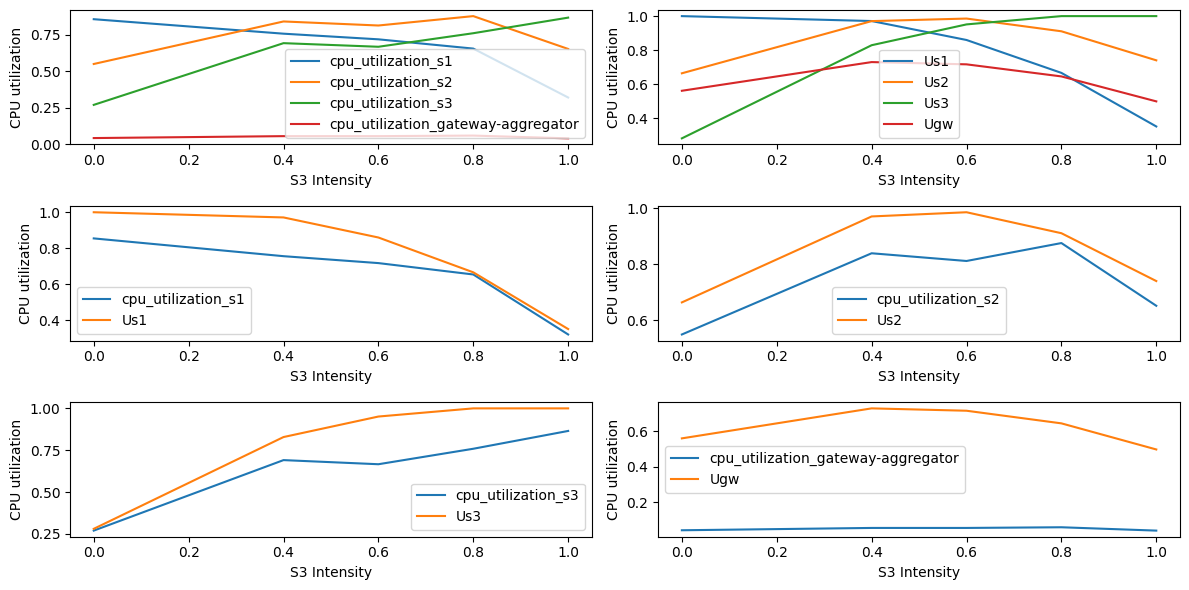

In [38]:
def plot_comparisons(comparison_tuples, df):
    # Calculate the number of subplots based on the length of comparison_tuples
    num_subplots = len(comparison_tuples)
    # Determine the number of rows and columns for the subplots
    num_rows = num_subplots // 2  # Assuming 2 columns
    num_cols = 2  # Number of columns for the subplots

    # Create a larger figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    # Flatten the axes array if there is more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, columns in enumerate(comparison_tuples):
        # Select the current subplot
        ax = axes[i]

        # Plot a line diagram for each pair of columns in the DataFrame
        x_column = "s3_intensity"
        for column in columns:
            df.plot(x=x_column, y=column, ax=ax)

        ax.set_xlabel("S3 Intensity")
        ax.set_ylabel("CPU utilization")

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    plt.show()


comparison_tuples = [
    ("cpu_utilization_s1", "cpu_utilization_s2", "cpu_utilization_s3", "cpu_utilization_gateway-aggregator"),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gateway-aggregator", "Ugw"),
]
plot_comparisons(comparison_tuples, df)

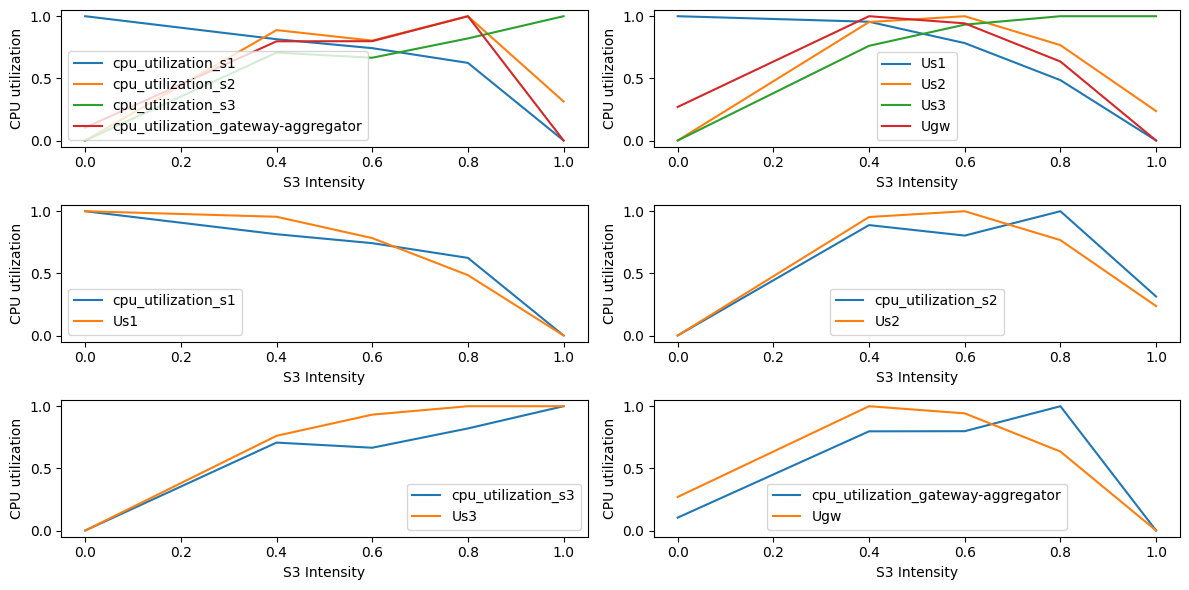

In [39]:
norm_df = pd.DataFrame()

for col in df.select_dtypes(include="number").columns:
    min_x, max_x = min(df[col]), max(df[col])
    norm_df[col] = df[col].transform(lambda x: normalize(x, min_x, max_x))

comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_gateway-aggregator",
    ),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gateway-aggregator", "Ugw"),
]
plot_comparisons(comparison_tuples, norm_df)

## Evaluation

In [40]:
comparison_tuples = [
    ("cpu_utilization_s1", "Us1"),
    ("cpu_utilization_s2", "Us2"),
    ("cpu_utilization_s3", "Us3"),
    ("cpu_utilization_gateway-aggregator", "Ugw"),
]

### Spearman's correlation coefficient

In [41]:
for real, expected in comparison_tuples:
    correlation_coefficient, p_value = spearmanr(df[expected], df[real])

    # Display the result
    print(
        f"Spearman's correlation coefficient {real}: {correlation_coefficient} ({p_value=})"
    )

Spearman's correlation coefficient cpu_utilization_s1: 0.9999999999999999 (p_value=1.4042654220543672e-24)
Spearman's correlation coefficient cpu_utilization_s2: 0.6 (p_value=0.28475697986529375)
Spearman's correlation coefficient cpu_utilization_s3: 0.8999999999999998 (p_value=0.03738607346849874)
Spearman's correlation coefficient cpu_utilization_gateway-aggregator: 0.6 (p_value=0.28475697986529375)


### Mean average (percentage) error

In [42]:
for real, expected in comparison_tuples:
    mape_score = mape(df[expected], df[real])
    mae_score = mae(df[expected], df[real])
    print(f"{real}: {mape_score=}, {mae_score=}")

    eps = 1
    norm_mape_score = mape(norm_df[expected] + eps, norm_df[real] + eps)
    norm_mae_score = mae(norm_df[expected], norm_df[real])
    print(f"{real}: {norm_mape_score=} ({eps=}), {norm_mae_score=}\n")

cpu_utilization_s1: mape_score=0.15340891569721377, mae_score=0.10912705967909446
cpu_utilization_s1: norm_mape_score=0.037265619434806954 (eps=1), norm_mae_score=0.06404144062493426

cpu_utilization_s2: mape_score=0.15125449209851927, mae_score=0.10879469501306346
cpu_utilization_s2: norm_mape_score=0.06365098536272573 (eps=1), norm_mae_score=0.11420728008941865

cpu_utilization_s3: mape_score=0.2280091150814349, mae_score=0.1618542756928302
cpu_utilization_s3: norm_mape_score=0.05797215162540546 (eps=1), norm_mae_score=0.09989178814467106

cpu_utilization_gateway-aggregator: mape_score=11.258219859535496, mae_score=0.5782829970176607
cpu_utilization_gateway-aggregator: norm_mape_score=0.10505313205408055 (eps=1), norm_mae_score=0.1753280981372248

